# Lab 6

## Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## Open dataset

In [2]:
train_df = pd.read_csv('../fashion-mnist_train.csv')
test_df = pd.read_csv('../fashion-mnist_test.csv')

In [3]:
train_df.head() # verify ds is loaded

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# divide images and labels
train_data = np.asarray(train_df,dtype=np.int32)
test_data = np.asarray(test_df,dtype=np.int32)
x_train = train_data[:,1:]
y_train = train_data[:,0]
x_test = test_data[:,1:]
y_test = test_data[:,0]

In [5]:
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val = train_test_split(x_train,y_train,test_size=.25,random_state=42)

In [6]:
# assign image labels
class_names = ['T_shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [7]:
# function to display one cloth image
def plot_cloth(data, class_name=""):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    if class_name != "":
        plt.title(class_names[int(class_name)])
    plt.axis("off")

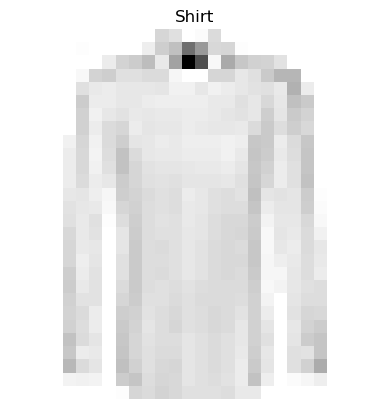

In [8]:
# display some image
plot_cloth(x_train[42], y_train[42])

In [9]:
# function to display many clothes images
def plot_clothes(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # If needed, add empty images to fill up to the end of the grid:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Now contains 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Show the final result
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

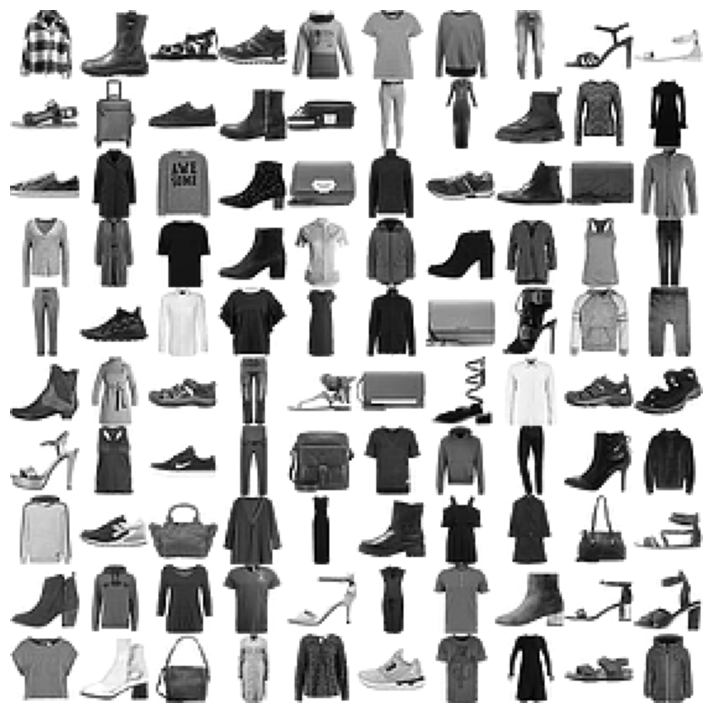

In [10]:
plt.figure(figsize=(9,9))
example_images = x_train[:100]
plot_clothes(example_images, images_per_row=10)
plt.show()

In [11]:
y_train = y_train.astype(np.uint8)

In [12]:
y_train

array([4, 9, 5, ..., 9, 4, 0], dtype=uint8)

## Training a binary classifier

In [13]:
# find some trousers
y_train_trousers = (y_train == 1)
y_test_trousers = (y_test == 1)

In [14]:
from sklearn.linear_model import SGDClassifier

# train SGD classifier
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(x_train, y_train_trousers)

SGDClassifier(random_state=42)

In [15]:
# test if trousers is indeed trousers
some_clothes = x_train[7]
sgd_clf.predict([some_clothes])

array([ True])

In [16]:
# measure accuracy
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, x_train, y_train_trousers, cv=3, scoring="accuracy")

array([0.98893333, 0.98093333, 0.9892    ])

## Performance measures

### Measuring Accuracy Using Cross-Validation

In [17]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# manual crossvalidation
for train_index, test_index in skfolds.split(x_train, y_train_trousers):
    clone_clf = clone(sgd_clf)
    X_train_folds = x_train[train_index]
    y_train_folds = y_train_trousers[train_index]
    X_test_fold = x_train[test_index]
    y_test_fold = y_train_trousers[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9892666666666666
0.992
0.9892666666666666


In [18]:
from sklearn.base import BaseEstimator
class NeverTrousersClassifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [20]:
# creating and showing off never trousers classifier
never_trousers_clf = NeverTrousersClassifier()
cross_val_score(never_trousers_clf, x_train, y_train_trousers, cv=3, scoring="accuracy")

array([0.90026667, 0.89673333, 0.9016    ])

### Confusion Matrix

In [21]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, x_train, y_train_trousers, cv=3)

In [22]:
from sklearn.metrics import confusion_matrix

# confusions matrix for never trousers binary classifier
confusion_matrix(y_train_trousers, y_train_pred)

array([[40020,   459],
       [  155,  4366]])

In [23]:
y_train_perfect_predictions = y_train_trousers  # pretend we reached perfection
# confusion matrix for perfect classifier
confusion_matrix(y_train_trousers, y_train_perfect_predictions)

array([[40479,     0],
       [    0,  4521]])

### Precision and Recall

In [24]:
from sklearn.metrics import precision_score, recall_score

# show precision score
precision_score(y_train_trousers, y_train_pred)

0.9048704663212436

In [25]:
# calc precision score manually
cm = confusion_matrix(y_train_trousers, y_train_pred)
cm[1, 1] / (cm[0, 1] + cm[1, 1])

0.9048704663212436

In [26]:
# show recall score
recall_score(y_train_trousers, y_train_pred)

0.9657155496571554

In [27]:
# calc recall score manually
cm[1, 1] / (cm[1, 0] + cm[1, 1])

0.9657155496571554

In [30]:
from sklearn.metrics import f1_score

# show f1 score
f1_score(y_train_trousers, y_train_pred)

0.934303445324203

In [31]:
# calc f1 score manually
cm[1, 1] / (cm[1, 1] + (cm[1, 0] + cm[0, 1]) / 2)

0.9343034453242028

### Precision/Recall Trade-off

In [32]:
# score for some cloth
y_scores = sgd_clf.decision_function([some_clothes])
y_scores

array([35501.91236856])

In [33]:
# manually set threshold to 0 (this is default value of SGD classifier)
threshold = 0
y_some_clothes_pred = (y_scores > threshold)
y_some_clothes_pred

array([ True])

In [34]:
# set threshold too high, so that even trousers are not more thousers
threshold = 36000
y_some_clothes_pred = (y_scores > threshold)
y_some_clothes_pred

array([False])

In [36]:
# get decision scores of instances
y_scores = cross_val_predict(sgd_clf, x_train, y_train_trousers, cv=3,
                             method="decision_function")

In [37]:
from sklearn.metrics import precision_recall_curve

# compute precisions and recalls for all possible thresholds
precisions, recalls, thresholds = precision_recall_curve(y_train_trousers, y_scores)

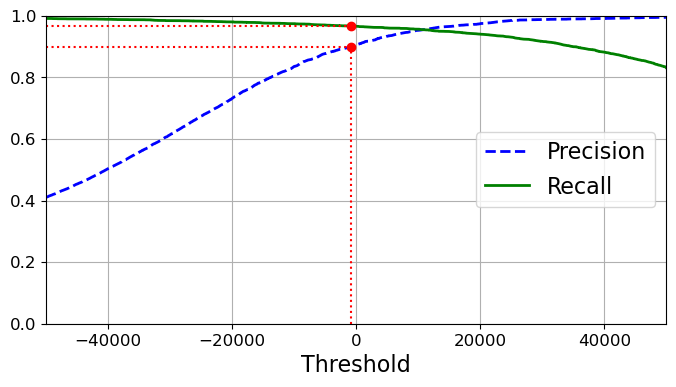

In [38]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)        
    plt.grid(True)                              
    plt.axis([-50000, 50000, 0, 1])             



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                             
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             
plt.show()

In [39]:
(y_train_pred == (y_scores > 0)).all()

True

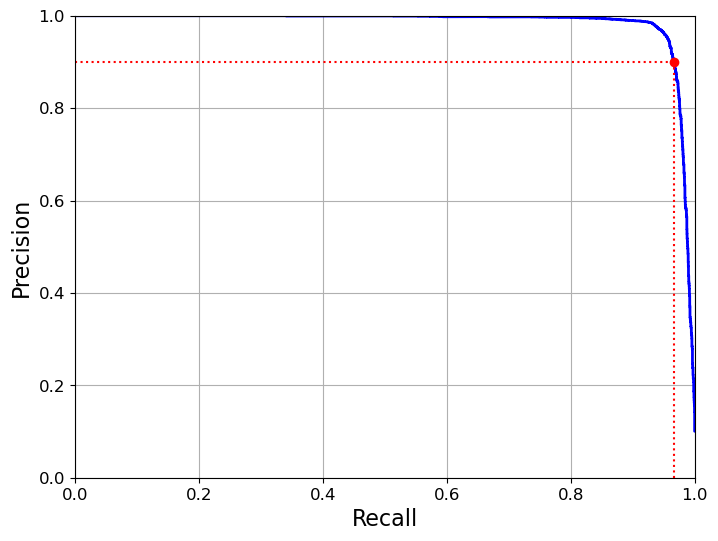

In [41]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
plt.show()

In [42]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

-859.1717031351617

In [43]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [45]:
precision_score(y_train_trousers, y_train_pred_90)

0.9001029866117405

In [46]:
recall_score(y_train_trousers, y_train_pred_90)

0.9666003096660031

### The ROC Curve

In [48]:
from sklearn.metrics import roc_curve

# compute PFR and TPR for various threshold values
fpr, tpr, thresholds = roc_curve(y_train_trousers, y_scores)

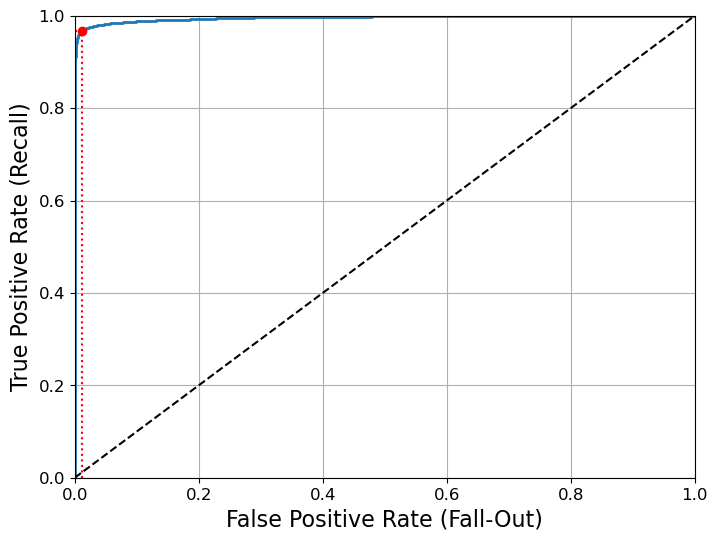

In [49]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.show()

In [51]:
from sklearn.metrics import roc_auc_score

# compute Area under the curve (AUC)
roc_auc_score(y_train_trousers, y_scores)

0.9954324775456684

In [53]:
from sklearn.ensemble import RandomForestClassifier

# train random forest classifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, x_train, y_train_trousers, cv=3,
                                    method="predict_proba")

In [55]:
# compute the same values for RFClassifier
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_trousers,y_scores_forest)

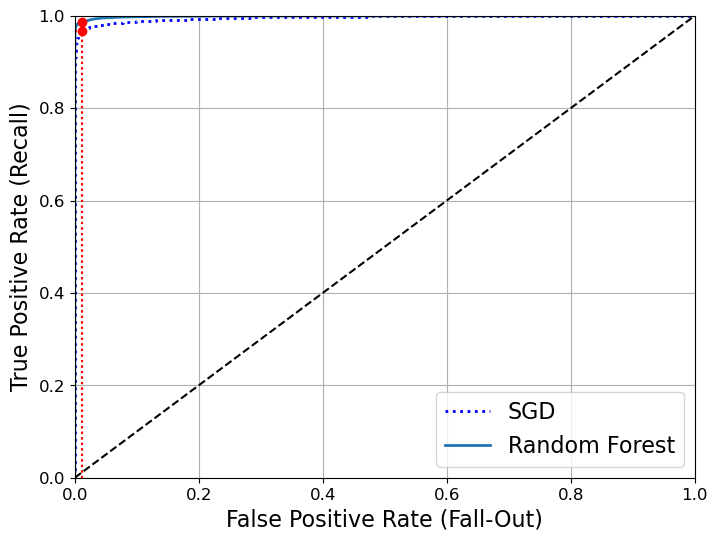

In [56]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [57]:
# as we can see, RF classifier is better
roc_auc_score(y_train_trousers, y_scores_forest)

0.998889765966071

In [58]:
y_train_pred_forest = cross_val_predict(forest_clf, x_train, y_train_trousers, cv=3)
precision_score(y_train_trousers, y_train_pred_forest)

0.9983743613562471

In [59]:
recall_score(y_train_trousers, y_train_pred_forest)

0.9508958195089582

## Multiclass Classification

In [60]:
from sklearn.svm import SVC

# Support Vector classifier and One-versus-One strategy
svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(x_train[:1000], y_train[:1000])
svm_clf.predict([some_clothes])

array([1], dtype=uint8)

In [61]:
# we see that indeed OvO strategy was used and for each instance we get 10 scores
some_clothes_scores = svm_clf.decision_function([some_clothes])
some_clothes_scores

array([[ 0.7712041 ,  9.2999895 ,  7.95516039, -0.23446107,  2.82995637,
         4.87190963,  1.82995637,  3.83708759,  6.95516039,  5.89447206]])

In [62]:
np.argmax(some_clothes_scores)

1

In [63]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [64]:
from sklearn.multiclass import OneVsRestClassifier

# lets now create a multiclass classifier using the OvR strategy, based on an SVC
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(x_train[:1000], y_train[:1000])
ovr_clf.predict([some_clothes])

array([1], dtype=uint8)

In [65]:
# indeed 10 estimators (one-versus-all)
len(ovr_clf.estimators_)

10

In [66]:
# training SGDClassifier
sgd_clf.fit(x_train, y_train)
sgd_clf.predict([some_clothes])

array([1], dtype=uint8)

In [67]:
# scores SGDClassifier assigned to each class. It is confident about 1.
sgd_clf.decision_function([some_clothes])

array([[ -31764.07125876,   18608.16894553,  -13020.86689108,
          -4159.15171881,   -4099.83055496, -131506.45130894,
         -13646.62234262, -124879.29448656,  -29352.76687174,
         -85908.41359746]])

In [68]:
# cross val score for this classifier
cross_val_score(sgd_clf, x_train, y_train, cv=3, scoring="accuracy")

array([0.78926667, 0.81526667, 0.80566667])

In [69]:
from sklearn.preprocessing import StandardScaler

# scale the inputs to get better classifier
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.astype(np.float64))
cross_val_score(sgd_clf, x_train_scaled, y_train, cv=3, scoring="accuracy")

/Users/nksazonov/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/nksazonov/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/nksazonov/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


array([0.833     , 0.82933333, 0.8338    ])

## Error Analysis

In [70]:
# get consusions matrix
y_train_pred = cross_val_predict(sgd_clf, x_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

/Users/nksazonov/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/nksazonov/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/nksazonov/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


array([[3517,   16,   85,  318,   21,    0,  453,    0,   71,    0],
       [  12, 4274,   34,  155,   19,    0,   23,    0,    4,    0],
       [  30,    6, 3260,   76,  584,    0,  504,    0,   46,    0],
       [ 183,   58,   59, 3831,  157,    0,  162,    0,    9,    0],
       [   5,    4,  474,  262, 3314,    0,  441,    0,   17,    0],
       [   1,    1,    3,    7,    0, 4191,   12,  200,   53,   97],
       [ 588,   12,  502,  283,  389,    0, 2524,    1,  140,    0],
       [   0,    0,    0,    0,    0,  186,    0, 4051,   17,  205],
       [  19,    4,   17,   95,   27,    6,  102,   26, 4252,    5],
       [   0,    0,    0,    2,    1,   82,    5,  178,    4, 4228]])

In [71]:
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

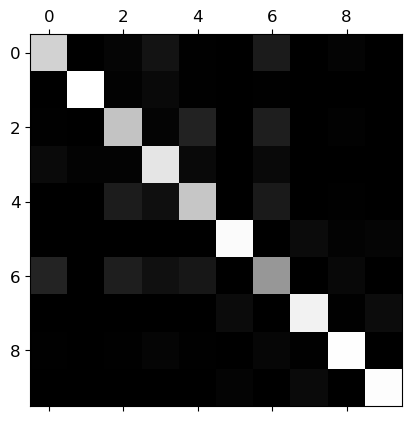

In [72]:
# show confusion matrix as an image
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [73]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

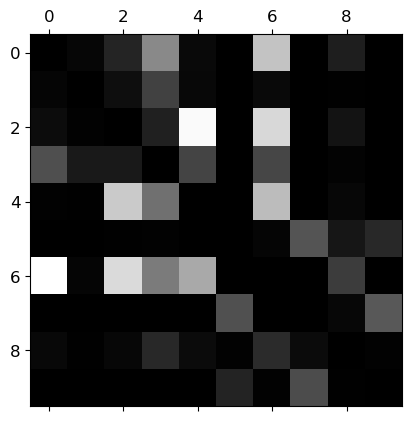

In [74]:
# normalize confusion matrix results, so that we can see errors easily
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

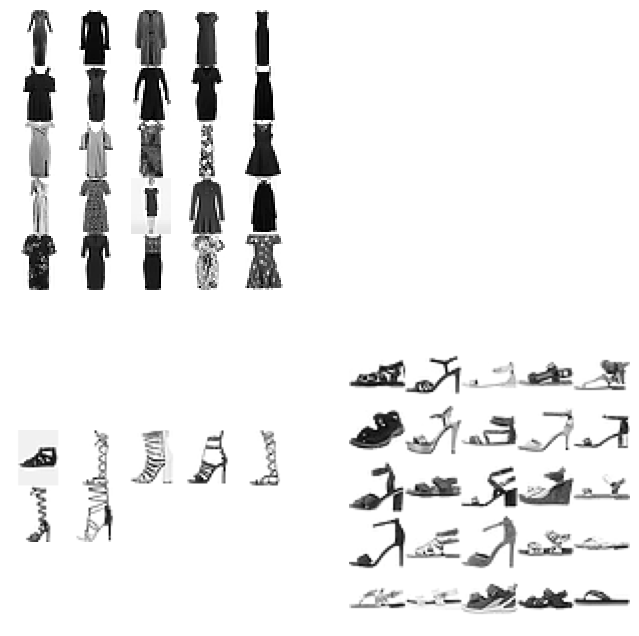

In [77]:
# plot examples of TN, FN, FP, TP for Dress and Sandal
cl_a, cl_b = 3, 5
X_aa = x_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = x_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = x_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = x_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221)
if len(X_aa) > 0:
    plot_clothes(X_aa[:25], images_per_row=5)
if len(X_ab) > 0:
    plt.subplot(222); plot_clothes(X_ab[:25], images_per_row=5)
if len(X_ba) > 0:
    plt.subplot(223); plot_clothes(X_ba[:25], images_per_row=5)
if len(X_bb) > 0:
    plt.subplot(224); plot_clothes(X_bb[:25], images_per_row=5)
plt.show()

## Multilabel Classification

In [78]:
from sklearn.neighbors import KNeighborsClassifier

# define some labels for our data
y_train_shoes = (y_train == 5) | (y_train == 7) | (y_train == 9)
y_train_tops = (y_train == 0) | (y_train == 2) | (y_train == 4) | (y_train == 6)
y_multilabel = np.c_[y_train_shoes, y_train_tops]

knn_clf = KNeighborsClassifier()
knn_clf.fit(x_train, y_multilabel)

KNeighborsClassifier()

In [79]:
knn_clf.predict([some_clothes])

array([[False, False]])

In [80]:
# compute F1 score for this classifier
y_train_knn_pred = cross_val_predict(knn_clf, x_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.9792744794454784

## Multioutput Classification

In [81]:
# add noise
noise = np.random.randint(0, 100, (len(x_train), 784))
x_train_mod = x_train + noise
noise = np.random.randint(0, 100, (len(x_test), 784))
X_test_mod = x_test + noise
y_train_mod = x_train
y_test_mod = x_test

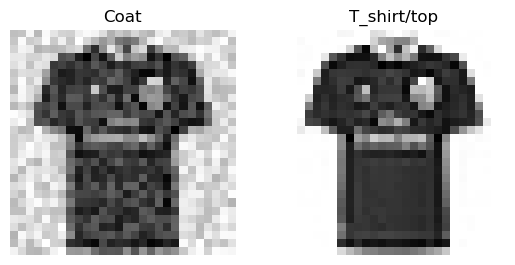

In [83]:
# show with noise
some_index = 0
plt.subplot(121); plot_cloth(X_test_mod[some_index], y_train[some_index])
plt.subplot(122); plot_cloth(y_test_mod[some_index], y_test[some_index])
plt.show()

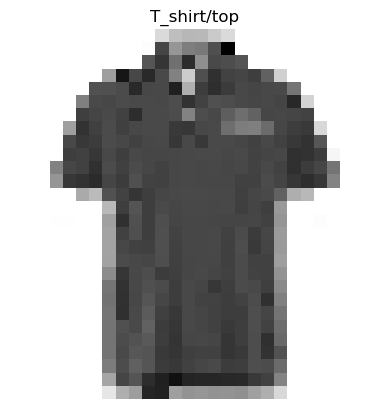

In [84]:
# train a classifier and make it clean this image
knn_clf.fit(x_train_mod, y_train_mod)
clean_clothes = knn_clf.predict([X_test_mod[some_index]])
plot_cloth(clean_clothes, y_test[some_index])